# Erddapy
This notebook demonstrates using [erddapy](https://ioos.github.io/erddapy/) to retrieve data on ERDDAP systems.

## NOAA Polarwatch
Let's get some data from the [NOAA Polarwarch ERDDAP](https://polarwatch.noaa.gov/erddap/index.html). The datasets we want to use, and most of the datasets on this ERDDAP server are "griddap" datasets, so we will use the "griddap" protocol when creating the erddapy ERDDAP object:

In [1]:
from erddapy import ERDDAP
e = ERDDAP(
    server='https://polarwatch.noaa.gov/erddap',
    protocol='griddap')

The Dataset ID can be found in each dataset's search page, such as in this example:
<div style="clear:left;">
<img src='erddap.png' width=65% align='left' style='margin: 0px 30px'>
</div>

So we will start by downloading the lat/lon grid for the NOAA/NSIDC sea ice concentration data.

In [2]:
e.dataset_id = 'nsidcCDRice_sh_grid' #https://polarwatch.noaa.gov/erddap/griddap/nsidcCDRice_sh_grid.html

The griddap_initialize function initializes the constraints and variables in a dataset:

In [3]:
e.griddap_initialize()

import json
print(f'variables in this dataset:\n\n{e.variables}')
print(f'\nconstraints for this dataset:\n\n{json.dumps(e.constraints, indent=1)}')

variables in this dataset:

['latitude', 'longitude']

constraints for this dataset:

{
 "ygrid>=": 4337500.0,
 "ygrid<=": -3937500.0,
 "ygrid_step": 1,
 "xgrid>=": -3937500.0,
 "xgrid<=": 3937500.0,
 "xgrid_step": 1
}


For this dataset we do not need to change any constraints so we will open the entire dataset with Xarray and use .load() to actually download the data.

In [4]:
ds_ll = e.to_xarray()
ds_ll.load()

<xarray.Dataset>
Dimensions:    (ygrid: 332, xgrid: 316)
Coordinates:
  * ygrid      (ygrid) float32 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
  * xgrid      (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
Data variables:
    latitude   (ygrid, xgrid) float64 -39.36 -39.49 -39.62 ... -41.72 -41.58
    longitude  (ygrid, xgrid) float64 -42.23 -42.05 -41.87 ... 135.4 135.2 135.0
Attributes: (12/65)
    acknowledgement:                        This project was supported in par...
    cdm_data_type:                          Grid
    cdr_variable:                           seaice_conc_cdr
    contributor_name:                       Walt Meier, Ruth Duerr, Florence ...
    contributor_role:                       PrincipalInvestigator,author,auth...
    Conventions:                            CF-1.6, COARDS, ACDD-1.3
    ...                                     ...
    standard_parallel:                      -70.0
    straight_vertical_longitude_from_pole:  180.0
    summary:                                This data set provides a Climate ...
    time_coverage_duration:                 P1D
    time_coverage_resolution:               P1D
    title:                                  Sea Ice Concentration Lat-Lon Gri...

Next let's look at a sea ice concentration dataset. We will use the same ERDDAP object but change the dataset_id, and then run the initialize function again to see the new data variables.

In [5]:
e.dataset_id='nsidcG02202v4sh1day' # https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nh1day.html

In [6]:
e.griddap_initialize()
print(f'variables in this dataset:\n\n{e.variables}')
print(f'\nconstraints for this dataset:\n\n{json.dumps(e.constraints, indent=1)}'
)

variables in this dataset:

['cdr_seaice_conc', 'nsidc_bt_seaice_conc', 'nsidc_nt_seaice_conc', 'qa_of_cdr_seaice_conc', 'spatial_interpolation_flag', 'stdev_of_cdr_seaice_conc', 'temporal_interpolation_flag']

constraints for this dataset:

{
 "time>=": "2022-05-31T00:00:00Z",
 "time<=": "2022-05-31T00:00:00Z",
 "time_step": 1,
 "ygrid>=": 4337500.0,
 "ygrid<=": -3937500.0,
 "ygrid_step": 1,
 "xgrid>=": -3937500.0,
 "xgrid<=": 3937500.0,
 "xgrid_step": 1
}


This output shows that the latest data in the dataset are from 2022-05-31. We can limit our download to just the variables that we want, and change the time constraints to more than just one point.

In [7]:
e.variables = ['cdr_seaice_conc'] # this must be a list even if just one element
e.constraints['time>='] = '2021-01-01T00:00:00Z'

In [8]:
ds = e.to_xarray()
ds

<xarray.Dataset>
Dimensions:          (time: 516, ygrid: 332, xgrid: 316)
Coordinates:
  * time             (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2022-05-31
  * ygrid            (ygrid) float32 4.338e+06 4.312e+06 ... -3.938e+06
  * xgrid            (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
Data variables:
    cdr_seaice_conc  (time, ygrid, xgrid) float32 ...
Attributes: (12/64)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    Conventions:                                         CF-1.6, ACDD-1.3, CO...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1D
    time_coverage_end:                                   2022-05-31T00:00:00Z
    time_coverage_resolution:                            P1D
    time_coverage_start:                                 2021-01-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

Next let's merge the lat/lon coords into this dataset. I don't think this is required to plot with Cartopy but we'll do it anyway for now.

In [9]:
import xarray as xr

In [10]:
ds_ice = xr.merge([ds, ds_ll])

In [11]:
ds_ice

<xarray.Dataset>
Dimensions:          (time: 516, ygrid: 332, xgrid: 316)
Coordinates:
  * time             (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2022-05-31
  * ygrid            (ygrid) float32 4.338e+06 4.312e+06 ... -3.938e+06
  * xgrid            (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
Data variables:
    cdr_seaice_conc  (time, ygrid, xgrid) float32 ...
    latitude         (ygrid, xgrid) float64 -39.36 -39.49 ... -41.72 -41.58
    longitude        (ygrid, xgrid) float64 -42.23 -42.05 -41.87 ... 135.2 135.0
Attributes: (12/64)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    Conventions:                                         CF-1.6, ACDD-1.3, CO...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1D
    time_coverage_end:                                   2022-05-31T00:00:00Z
    time_coverage_resolution:                            P1D
    time_coverage_start:                                 2021-01-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

In [12]:
ds_ice.set_coords(['latitude', 'longitude'])

<xarray.Dataset>
Dimensions:          (time: 516, ygrid: 332, xgrid: 316)
Coordinates:
  * time             (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2022-05-31
  * ygrid            (ygrid) float32 4.338e+06 4.312e+06 ... -3.938e+06
  * xgrid            (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
    latitude         (ygrid, xgrid) float64 -39.36 -39.49 ... -41.72 -41.58
    longitude        (ygrid, xgrid) float64 -42.23 -42.05 -41.87 ... 135.2 135.0
Data variables:
    cdr_seaice_conc  (time, ygrid, xgrid) float32 ...
Attributes: (12/64)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    Conventions:                                         CF-1.6, ACDD-1.3, CO...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1D
    time_coverage_end:                                   2022-05-31T00:00:00Z
    time_coverage_resolution:                            P1D
    time_coverage_start:                                 2021-01-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

In [13]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

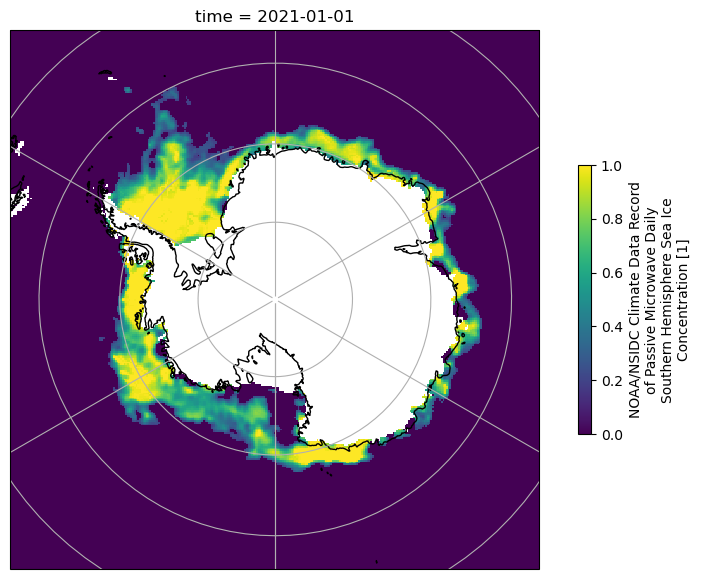

In [14]:
fig = plt.figure(figsize=(10,7))
proj_ant = ccrs.SouthPolarStereo()
ax = plt.axes(projection=proj_ant)
ax.set_extent([-180, 180, -90, -56], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

ice_conc = ds_ice.cdr_seaice_conc[0]
ice_conc = ice_conc.where(ice_conc<=1)
ice_conc.plot(vmin=0, vmax=1, cbar_kwargs={'shrink': 0.5})

Let's switch to the monthly dataset so we can quickly download all the time slices.

In [15]:
e.dataset_id = 'nsidcG02202v4shmday' # https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday.html

In [16]:
e.griddap_initialize()
print(f'variables in this dataset:\n\n{e.variables}')
print(f'\nconstraints for this dataset:\n\n{json.dumps(e.constraints, indent=1)}')

variables in this dataset:

['cdr_seaice_conc_monthly', 'nsidc_bt_seaice_conc_monthly', 'nsidc_nt_seaice_conc_monthly', 'qa_of_cdr_seaice_conc_monthly', 'stdev_of_cdr_seaice_conc_monthly']

constraints for this dataset:

{
 "time>=": "2022-05-01T00:00:00Z",
 "time<=": "2022-05-01T00:00:00Z",
 "time_step": 1,
 "ygrid>=": 4337500.0,
 "ygrid<=": -3937500.0,
 "ygrid_step": 1,
 "xgrid>=": -3937500.0,
 "xgrid<=": 3937500.0,
 "xgrid_step": 1
}


Set the constraints to None in order to get all the data for the specified variables.

In [17]:
e.variables = ['cdr_seaice_conc_monthly'] # this must be a list even if just one element
e.constraints = None

In [18]:
ds = e.to_xarray()
ds

<xarray.Dataset>
Dimensions:                  (time: 523, ygrid: 332, xgrid: 316)
Coordinates:
  * time                     (time) datetime64[ns] 1978-11-01 ... 2022-05-01
  * ygrid                    (ygrid) float32 4.338e+06 4.312e+06 ... -3.938e+06
  * xgrid                    (xgrid) float32 -3.938e+06 -3.912e+06 ... 3.938e+06
Data variables:
    cdr_seaice_conc_monthly  (time, ygrid, xgrid) float32 ...
Attributes: (12/65)
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    Conventions:                                         CF-1.6, ACDD-1.3, CO...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2022-05-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 1978-11-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

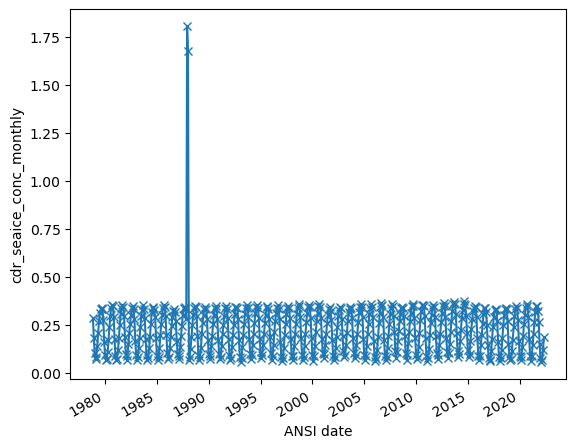

In [19]:
ice_monthly = ds.cdr_seaice_conc_monthly.mean(dim=('ygrid', 'xgrid'))
ds.cdr_seaice_conc_monthly.mean(dim=('ygrid', 'xgrid')).plot(marker='x');

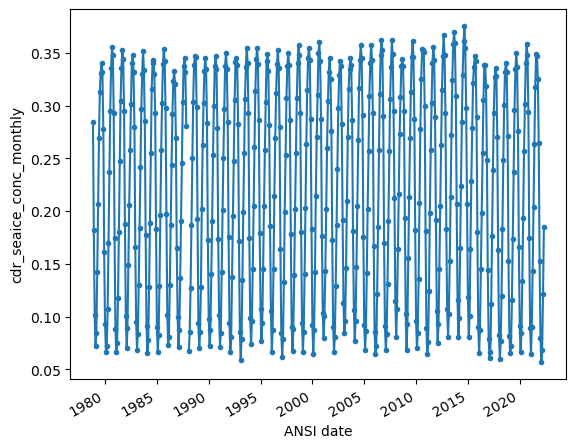

In [20]:
ice_monthly.where(ice_monthly<0.5).plot(marker='.');